###**Library & Dependencies**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as tt
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models

from torchvision.datasets import CIFAR100
from tqdm import tqdm

###**Load DataSet, Dataloader**

In [2]:
stats = ((0.5,0.5,0.5),(0.5,0.5,0.5))
#transforming training set.
train_transform = tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.RandomCrop(32, padding=4, padding_mode="reflect"),
    tt.ToTensor(),        # 3 channels: RGB, tensor.size=[3*32*32]
    tt.Normalize(*stats)  # to ensure gradients don't diverge
])
#transforming test set
val_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats) 
])

train_data = CIFAR100(download=True, root="./data", transform=train_transform)
val_data = CIFAR100(root="./data", train=False, transform=val_transform)

print(train_data[0])
def load_data(batch_size):
    train_loader = DataLoader(train_data,batch_size=batch_size, num_workers=2,
                          pin_memory=True, shuffle=True)
    
    val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=2,
                        pin_memory=True)
    
    return train_loader, val_loader

100%|██████████| 169001437/169001437 [00:01<00:00, 84891710.20it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
(tensor([[[ 1.0000,  1.0000,  1.0000,  ..., -0.0510,  0.3020,  0.4824],
         [ 1.0000,  1.0000,  1.0000,  ..., -0.0588,  0.1686,  0.3098],
         [ 1.0000,  1.0000,  1.0000,  ..., -0.0118,  0.1294,  0.2314],
         ...,
         [-0.2078, -0.3333, -0.4353,  ...,  0.0824, -0.1765, -0.7333],
         [-0.0118, -0.2235, -0.2706,  ...,  0.1059, -0.2392, -0.8275],
         [ 0.0980,  0.0510,  0.0980,  ..., -0.4039, -0.4902, -0.7647]],

        [[ 1.0000,  1.0000,  1.0000,  ...,  0.0431,  0.3961,  0.5608],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.0275,  0.2706,  0.4196],
         [ 1.0000,  1.0000,  1.0000,  ...,  0.0431,  0.1922,  0.2863],
         ...,
         [ 0.0510, -0.0824, -0.1843,  ...,  0.3569,  0.0431, -0.7176],
         [ 0.2549,  0.0588,  0.0118,  ...,  0.2627, -0.1216, -0.8745],
         [ 0.4039,  0.3569,  0.3725,  ..., -0.3961, -0.5137, -0.8667]],

        [[ 1.0000,  1.0000,  1.0000,  ..., -0.3176,  0.0196,  0

###**HandMade ResNet18 Model**

In [3]:
from torch import Tensor
from typing import Type

class BasicBlock (nn.Module):
  def __init__(self, in_channels, out_channels, stride=1, expansion=1, downsample=None):
    super(BasicBlock, self).__init__()
    self.expansion = expansion
    self.downsample = downsample
    self.conv1 = nn.Conv2d(in_channels, out_channels,kernel_size=3,stride=stride,
                           padding=1,bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(out_channels,out_channels*self.expansion,
                           kernel_size=3, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)

  def forward(self, x):
    identity = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    
    if self.downsample is not None: identity = self.downsample(x)
    out += identity
    out = self.relu(out)
    return out

class ResNet18(nn.Module):
  def __init__(self, img_channels, num_layers,block,num_classes=1000):
    super(ResNet18,self).__init__()
    if num_layers == 18:
      layers = [2,2,2,2]
      self.expansion = 1
    
    self.in_channels = 64
    self.conv1 = nn.Conv2d(in_channels = img_channels, 
                           out_channels=self.in_channels,kernel_size=7,stride=2,
                           padding=3,bias=False)
    self.bn1 = nn.BatchNorm2d(self.in_channels)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1 = self._make_layer(block,64,layers[0])
    self.layer2 = self._make_layer(block,128,layers[1], stride=2)
    self.layer3 = self._make_layer(block,256,layers[2], stride=2)
    self.layer4 = self._make_layer(block,512,layers[3], stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512*self.expansion,num_classes)

  def _make_layer(self,block,out_channels,blocks,stride=1) -> nn.Sequential:
    downsample = None
    if stride != 1:
      downsample = nn.Sequential(nn.Conv2d(self.in_channels,
                                           out_channels*self.expansion,
                                           kernel_size=1,stride=stride,bias=False)
      ,nn.BatchNorm2d(out_channels*self.expansion),)
    layers = []
    layers.append(block(self.in_channels, out_channels, stride,self.expansion,
                        downsample))
    self.in_channels = out_channels*self.expansion

    for i in range(1, blocks):
      layers.append(block(self.in_channels, out_channels, expansion=self.expansion))
    return nn.Sequential(*layers)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    #print('Dimensions of the last convolutional feature map: ', x.shape)

    x = self.avgpool(x)
    x = torch.flatten(x,1)
    x = self.fc(x)

    return x

###**Plots** <br> *to be done via* ```torch.utils.tensorboard```

In [4]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='tab:blue', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='tab:red', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='tab:blue', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='tab:red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

###**Training Model**

In [5]:
def train(model, trainloader, optimizer, criterion, device):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader),
                        ncols=50, bar_format='\033[35m{l_bar}{bar}\033[0m'):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(image)

        # Calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()

        # Calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()

        # Backpropagation
        loss.backward()
        
        # Update the weights
        optimizer.step()
    
    # print("Predicted labels \n")
    # print(outputs)
    # print(outputs.shape)

    # print("Index of outputs")
    # print(preds)
    # print(preds.shape)

    # print("Target labels \n")
    # print(labels)
    # print(labels.shape)

    # Loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

###**Validation Model**

In [6]:
def validate(model, testloader, criterion, device):
    model.eval()
    print('\n'+'Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader),
                            ncols=50, bar_format='\033[36m{l_bar}{bar}\033[0m'):
            counter += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)

            # Forward pass.
            outputs = model(image)

            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

###**Seed**

In [7]:
import random
# Set seed.
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
np.random.seed(seed)
random.seed(seed)

###**Choosing Model**

In [8]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=c40b8ab35773a1c9c515b280d4e8d50d61dd8a0100a1a63c94396812bef6c3a8
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [9]:
args = {
    'model': 'ResNet18'
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


if args['model'] == 'ResNet18':
    print('[INFO]: Initiating ResNet18')
    model = ResNet18(img_channels=3, num_layers=18,
                     block=BasicBlock, num_classes=100).to(device)
    plot_name = 'ResNet18 - CIFAR100'

if args['model'] == 'EfficientNetB3':
    print('[INFO]: Initiating EfficientnetB3')
    model = torchvision.models.efficientnet_b3(num_classes=100).to(device)
    plot_name = 'EfficientNetB3 - CIFAR100'

if args['model'] == 'EfficientNetB0':
    print('[INFO]: Initiating EfficientnetB3')
    model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=100).to(device)
    plot_name = 'EfficientNetB0 - CIFAR100'

[INFO]: Initiating ResNet18


###**Hyper-Param**

In [10]:
#Hyper-Params
epochs = 20
batch_size = 256
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

###**Execute - Train( )**

In [11]:
train_loader, val_loader = load_data(batch_size)

train_loss = []
train_acc = []

for epoch in range(epochs):
  print(f"[INFO]: Epoch {epoch+1} of {epochs}")

  train_epoch_loss, train_epoch_acc = train(model,train_loader,optimizer,
                                            criterion,device)

  train_loss.append(train_epoch_loss)
  train_acc.append(train_epoch_acc)

  print(f"\nTraining loss: {train_epoch_loss:.2f}, Training acc: {train_epoch_acc:.1f}")
  print('-'*50)

print('TRAINING COMPLETE')

[INFO]: Epoch 1 of 20
Training


100%|█████████████████████████████████████████████

Training loss: 3.65, Training acc: 14.3
--------------------------------------------------
[INFO]: Epoch 2 of 20
Training



100%|█████████████████████████████████████████████

Training loss: 3.04, Training acc: 24.3
--------------------------------------------------
[INFO]: Epoch 3 of 20
Training



100%|█████████████████████████████████████████████

Training loss: 2.69, Training acc: 30.9
--------------------------------------------------
[INFO]: Epoch 4 of 20
Training



100%|█████████████████████████████████████████████

Training loss: 2.48, Training acc: 35.3
--------------------------------------------------
[INFO]: Epoch 5 of 20
Training



100%|█████████████████████████████████████████████

Training loss: 2.32, Training acc: 38.7
--------------------------------------------------
[INFO]: Epoch 6 of 20
Training



100%|█████████████████████████████████████████████

Training loss: 2.19, Training acc: 41.3
--------------------------------------------------
[INFO]: Epoch 7 of 20
Training



100%|█████████████████████████████████████████████

Training loss: 2.07, Training acc: 44.1
--------------------------------------------------
[INFO]: Epoch 8 of 20
Training



100%|█████████████████████████████████████████████

Training loss: 1.98, Training acc: 46.0
--------------------------------------------------
[INFO]: Epoch 9 of 20
Training



100%|█████████████████████████████████████████████

Training loss: 1.89, Training acc: 48.1
--------------------------------------------------
[INFO]: Epoch 10 of 20
Training



100%|█████████████████████████████████████████████

Training loss: 1.81, Training acc: 49.8
--------------------------------------------------
[INFO]: Epoch 11 of 20
Training



100%|█████████████████████████████████████████████


Training loss: 1.74, Training acc: 51.6
--------------------------------------------------
[INFO]: Epoch 12 of 20
Training


100%|█████████████████████████████████████████████

Training loss: 1.65, Training acc: 53.5
--------------------------------------------------
[INFO]: Epoch 13 of 20
Training



100%|█████████████████████████████████████████████

Training loss: 1.58, Training acc: 55.3
--------------------------------------------------
[INFO]: Epoch 14 of 20
Training



100%|█████████████████████████████████████████████

Training loss: 1.53, Training acc: 56.7
--------------------------------------------------
[INFO]: Epoch 15 of 20
Training



100%|█████████████████████████████████████████████

Training loss: 1.46, Training acc: 58.2
--------------------------------------------------
[INFO]: Epoch 16 of 20
Training



100%|█████████████████████████████████████████████

Training loss: 1.40, Training acc: 59.6
--------------------------------------------------
[INFO]: Epoch 17 of 20
Training



100%|█████████████████████████████████████████████

Training loss: 1.34, Training acc: 61.0
--------------------------------------------------
[INFO]: Epoch 18 of 20
Training



100%|█████████████████████████████████████████████

Training loss: 1.29, Training acc: 62.2
--------------------------------------------------
[INFO]: Epoch 19 of 20
Training



100%|█████████████████████████████████████████████

Training loss: 1.23, Training acc: 64.2
--------------------------------------------------
[INFO]: Epoch 20 of 20
Training



100%|█████████████████████████████████████████████

Training loss: 1.18, Training acc: 65.2
--------------------------------------------------
TRAINING COMPLETE


###**Execute - Test( )**

[INFO]: Epoch 1 of 20

Validation


100%|█████████████████████████████████████████████


Inference time: 3.02 seconds
Validation loss: 1.90, Validation acc: 51.5
--------------------------------------------------
[INFO]: Epoch 2 of 20

Validation



100%|█████████████████████████████████████████████


Inference time: 2.87 seconds
Validation loss: 1.90, Validation acc: 51.5
--------------------------------------------------
[INFO]: Epoch 3 of 20

Validation



100%|█████████████████████████████████████████████


Inference time: 3.20 seconds
Validation loss: 1.90, Validation acc: 51.5
--------------------------------------------------
[INFO]: Epoch 4 of 20

Validation



100%|█████████████████████████████████████████████


Inference time: 3.14 seconds
Validation loss: 1.90, Validation acc: 51.5
--------------------------------------------------
[INFO]: Epoch 5 of 20

Validation



100%|█████████████████████████████████████████████


Inference time: 2.80 seconds
Validation loss: 1.90, Validation acc: 51.5
--------------------------------------------------
[INFO]: Epoch 6 of 20

Validation



100%|█████████████████████████████████████████████



Inference time: 2.86 seconds
Validation loss: 1.90, Validation acc: 51.5
--------------------------------------------------
[INFO]: Epoch 7 of 20

Validation


100%|█████████████████████████████████████████████


Inference time: 3.13 seconds
Validation loss: 1.90, Validation acc: 51.5
--------------------------------------------------
[INFO]: Epoch 8 of 20

Validation



100%|█████████████████████████████████████████████


Inference time: 3.18 seconds
Validation loss: 1.90, Validation acc: 51.5
--------------------------------------------------
[INFO]: Epoch 9 of 20

Validation



100%|█████████████████████████████████████████████


Inference time: 2.87 seconds
Validation loss: 1.90, Validation acc: 51.5
--------------------------------------------------
[INFO]: Epoch 10 of 20

Validation



100%|█████████████████████████████████████████████


Inference time: 2.80 seconds
Validation loss: 1.90, Validation acc: 51.5
--------------------------------------------------
[INFO]: Epoch 11 of 20

Validation



100%|█████████████████████████████████████████████


Inference time: 3.18 seconds
Validation loss: 1.90, Validation acc: 51.5
--------------------------------------------------
[INFO]: Epoch 12 of 20

Validation



100%|█████████████████████████████████████████████


Inference time: 3.32 seconds
Validation loss: 1.90, Validation acc: 51.5
--------------------------------------------------
[INFO]: Epoch 13 of 20

Validation



100%|█████████████████████████████████████████████


Inference time: 2.83 seconds
Validation loss: 1.90, Validation acc: 51.5
--------------------------------------------------
[INFO]: Epoch 14 of 20

Validation



100%|█████████████████████████████████████████████


Inference time: 2.87 seconds
Validation loss: 1.90, Validation acc: 51.5
--------------------------------------------------
[INFO]: Epoch 15 of 20

Validation



100%|█████████████████████████████████████████████


Inference time: 3.22 seconds
Validation loss: 1.90, Validation acc: 51.5
--------------------------------------------------
[INFO]: Epoch 16 of 20

Validation



100%|█████████████████████████████████████████████


Inference time: 3.22 seconds
Validation loss: 1.90, Validation acc: 51.5
--------------------------------------------------
[INFO]: Epoch 17 of 20

Validation



100%|█████████████████████████████████████████████


Inference time: 2.81 seconds
Validation loss: 1.90, Validation acc: 51.5
--------------------------------------------------
[INFO]: Epoch 18 of 20

Validation



100%|█████████████████████████████████████████████


Inference time: 2.83 seconds
Validation loss: 1.90, Validation acc: 51.5
--------------------------------------------------
[INFO]: Epoch 19 of 20

Validation



100%|█████████████████████████████████████████████


Inference time: 3.12 seconds
Validation loss: 1.90, Validation acc: 51.5
--------------------------------------------------
[INFO]: Epoch 20 of 20

Validation



100%|█████████████████████████████████████████████



Inference time: 3.23 seconds
Validation loss: 1.90, Validation acc: 51.5
--------------------------------------------------
TRAINING COMPLETE


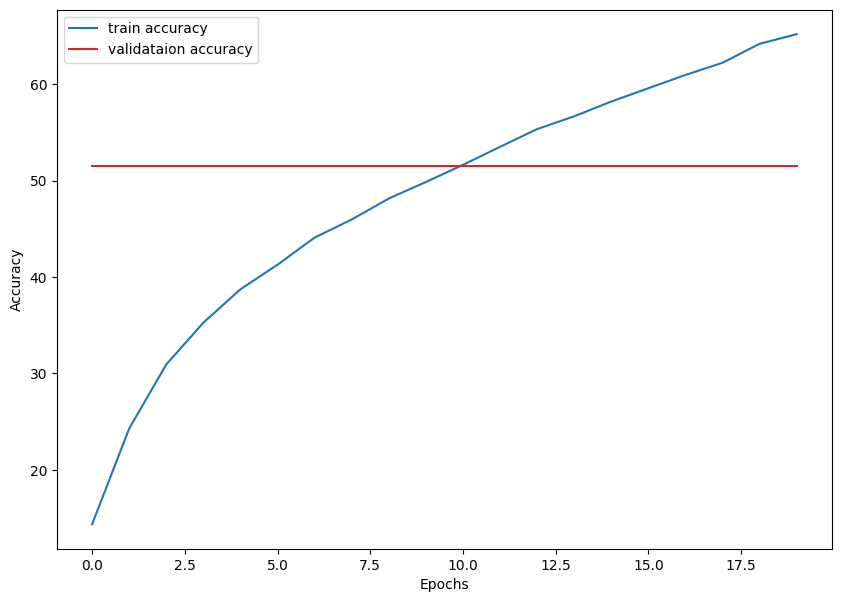

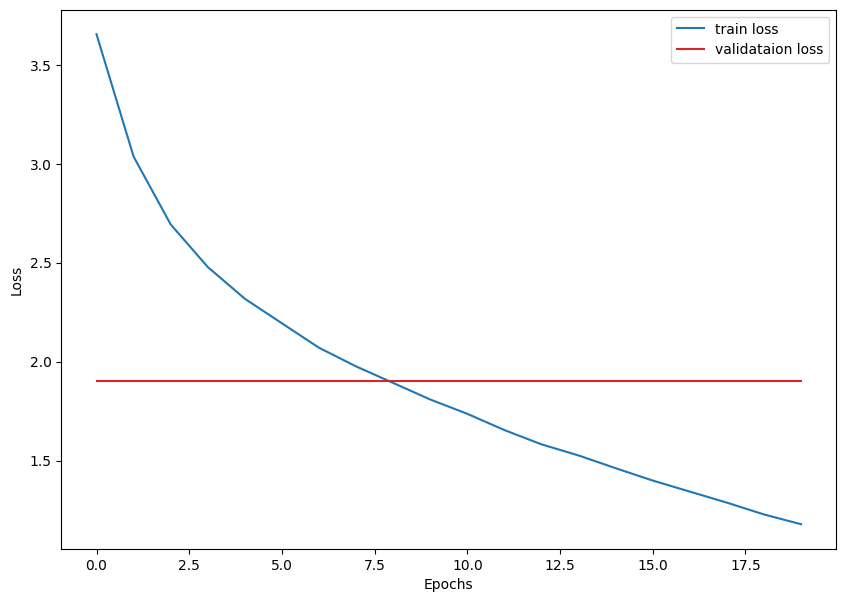

In [12]:
import time

train_loader, val_loader = load_data(batch_size)

valid_loss = []
valid_acc = []

for epoch in range(epochs):
  print(f"[INFO]: Epoch {epoch+1} of {epochs}")

  start_time = time.time()
  valid_epoch_loss, valid_epoch_acc = validate(model,val_loader,criterion,device)
  end_time = time.time()
  inference = end_time - start_time

  valid_loss.append(valid_epoch_loss)
  valid_acc.append(valid_epoch_acc)

  print(f"\nInference time: {inference:.2f} seconds")
  print(f"Validation loss: {valid_epoch_loss:.2f}, Validation acc: {valid_epoch_acc:.1f}")
  print('-'*50)

save_plots(
    train_acc,valid_acc,train_loss,valid_loss
)
print('TRAINING COMPLETE')
